In [1]:
import asyncio
import time
import logging

import vector; vector.register_awkward()

import cabinetry
from coffea.nanoevents.schemas.base import BaseSchema, zip_forms
from coffea import processor
from coffea.nanoevents.methods import base, vector
from coffea.nanoevents import transforms
import awkward as ak
import numpy as np
import hist
import json
import matplotlib.pyplot as plt
import uproot

import utils

logging.getLogger("cabinetry").setLevel(logging.INFO)

In [2]:
N_FILES_MAX_PER_SAMPLE = 5
NUM_CORES = 16
CHUNKSIZE = 500_000
IO_FILE_PERCENT = 4
USE_DASK = False
AF = "coffea_casa"

In [3]:
class AGCSchema(BaseSchema):
    def __init__(self, base_form):
        super().__init__(base_form)
        self._form["contents"] = self._build_collections(self._form["contents"])

    def _build_collections(self, branch_forms):
        names = set([k.split('_')[0] for k in branch_forms.keys() if not (k.startswith('number'))])
        # Remove n(names) from consideration. It's safe to just remove names that start with n, as nothing else begins with n in our fields.
        # Also remove GenPart, PV and MET because they deviate from the pattern of having a 'number' field.
        names = [k for k in names if not (k.startswith('n') | k.startswith('met') | k.startswith('GenPart') | k.startswith('PV'))]
        output = {}
        for name in names:
            offsets = transforms.counts2offsets_form(branch_forms['number' + name])
            content = {k[len(name)+1:]: branch_forms[k] for k in branch_forms if (k.startswith(name + "_") & (k[len(name)+1:] != 'e'))}
            # Add energy separately so its treated correctly by the p4 vector.
            content['energy'] = branch_forms[name+'_e']
            # Check for LorentzVector
            output[name] = zip_forms(content, name, 'PtEtaPhiELorentzVector', offsets=offsets)

        # Handle GenPart, PV, MET. Note that all the nPV_*'s should be the same. We just use one.
        output['met'] = zip_forms({k[len('met')+1:]: branch_forms[k] for k in branch_forms if k.startswith('met_')}, 'met')
        #output['GenPart'] = zip_forms({k[len('GenPart')+1:]: branch_forms[k] for k in branch_forms if k.startswith('GenPart_')}, 'GenPart', offsets=transforms.counts2offsets_form(branch_forms['numGenPart']))
        output['PV'] = zip_forms({k[len('PV')+1:]: branch_forms[k] for k in branch_forms if (k.startswith('PV_') & ('npvs' not in k))}, 'PV', offsets=transforms.counts2offsets_form(branch_forms['nPV_x']))
        return output

    @property
    def behavior(self):
        behavior = {}
        behavior.update(base.behavior)
        behavior.update(vector.behavior)
        return behavior

In [4]:
# functions creating systematic variations
def flat_variation(ones):
    # 0.1% weight variations
    return (1.0 + np.array([0.001, -0.001], dtype=np.float32)) * ones[:, None]


def btag_weight_variation(i_jet, jet_pt):
    # weight variation depending on i-th jet pT (10% as default value, multiplied by i-th jet pT / 50 GeV)
    return 1 + np.array([0.1, -0.1]) * (ak.singletons(jet_pt[:, i_jet]) / 50).to_numpy()


def jet_pt_resolution(pt):
    # normal distribution with 5% variations, shape matches jets
    counts = ak.num(pt)
    pt_flat = ak.flatten(pt)
    resolution_variation = np.random.normal(np.ones_like(pt_flat), 0.05)
    return ak.unflatten(resolution_variation, counts)


In [5]:
processor_base = processor.ProcessorABC
class SigBkgDiscrimination_4j2b(processor_base):
    def __init__(self, io_file_percent):
        self.io_file_percent = io_file_percent
    
    def process(self, events):
        
        process = events.metadata["process"]  # "ttbar" etc.
        variation = events.metadata["variation"]  # "nominal" etc.
        
        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378 # /pb
        if process != "data":
            xsec_weight = x_sec * lumi / nevts_total
        else:
            xsec_weight = 1
            
        if process == "wjets":
            events.add_systematic("scale_var", "UpDownSystematic", "weight", flat_variation)
            
        # jet energy scale / resolution systematics
        # need to adjust schema to instead use coffea add_systematic feature, especially for ServiceX
        # cannot attach pT variations to events.jet, so attach to events directly
        # and subsequently scale pT by these scale factors
        events["pt_nominal"] = 1.0
        events["pt_scale_up"] = 1.03
        events["pt_res_up"] = jet_pt_resolution(events.jet.pt)
        
        pt_variations = ["pt_nominal", "pt_scale_up", "pt_res_up"] if variation == "nominal" else ["pt_nominal"]
        for pt_var in pt_variations:
            
            # pT > 25 GeV for leptons & jets
            selected_electrons = events.electron[events.electron.pt > 25]
            selected_muons = events.muon[events.muon.pt > 25]
            jet_filter = events.jet.pt * events[pt_var] > 25  # pT > 25 GeV for jets (scaled by systematic variations)
            selected_jets = events.jet[jet_filter]
            
            # single lepton requirement
            event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
            # at least four jets
            pt_var_modifier = events[pt_var] if "res" not in pt_var else events[pt_var][jet_filter]
            event_filters = event_filters & (ak.count(selected_jets.pt * pt_var_modifier, axis=1) >= 4)
            # at least one b-tagged jet ("tag" means score above threshold)
            B_TAG_THRESHOLD = 0.5
            event_filters = event_filters & (ak.sum(selected_jets.btag >= B_TAG_THRESHOLD, axis=1) >= 1)
            
            # apply event filters
            selected_events = events[event_filters]
            selected_electrons = selected_electrons[event_filters]
            selected_muons = selected_muons[event_filters]
            selected_jets = selected_jets[event_filters]
            
            ### only consider 4j2b region
            region_filter = ak.sum(selected_jets.btag > B_TAG_THRESHOLD, axis=1) >= 2
            selected_jets_region = selected_jets[region_filter]
            selected_electrons_region = selected_electrons[region_filter]
            selected_muons_region = selected_muons[region_filter]
            
            # reconstruct hadronic top as bjj system with largest pT
            # the jet energy scale / resolution effect is not propagated to this observable at the moment
            trijet = ak.combinations(selected_jets_region, 3, fields=["j1", "j2", "j3"])  # trijet candidates
            trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # calculate four-momentum of tri-jet system
            deltar_0 = np.sqrt((trijet.j1.eta - trijet.j2.eta)**2 + (trijet.j1.phi - trijet.j2.phi)**2)
            deltar_1 = np.sqrt((trijet.j3.eta - trijet.j2.eta)**2 + (trijet.j3.phi - trijet.j2.phi)**2)
            deltar_2 = np.sqrt((trijet.j3.eta - trijet.j1.eta)**2 + (trijet.j3.phi - trijet.j1.phi)**2)
            trijet["avg_deltar"] = ak.mean(ak.concatenate([deltar_0[..., np.newaxis], deltar_1[..., np.newaxis], deltar_2[..., np.newaxis]], axis=2), axis=-1)
            trijet["max_btag"] = np.maximum(trijet.j1.btag, np.maximum(trijet.j2.btag, trijet.j3.btag))
            trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # require at least one-btag in trijet candidates
            # pick trijet candidate with largest pT and calculate mass of system
            trijet_mass = ak.flatten(trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass)
            trijet_deltar = ak.flatten(trijet["avg_deltar"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)])
            
            # get pt of either muon or electron (there should be exactly one of either for each event)
            lepton_pt = ak.sum(selected_electrons_region.pt,axis=-1) + ak.sum(selected_muons_region.pt,axis=-1) 
            
            # get pt of leading jet
            lj_pt = ak.max(selected_jets_region.pt,axis=-1)
            
            # HT (scalar sum of jet pT)
            pt_var_modifier = events[event_filters][region_filter][pt_var] if "res" not in pt_var else events[pt_var][jet_filter][event_filters][region_filter]
            ht = ak.sum(selected_jets_region.pt * pt_var_modifier, axis=-1)
            
        features = ak.concatenate([trijet_mass[..., np.newaxis], 
                                   trijet_deltar[..., np.newaxis], 
                                   lepton_pt[..., np.newaxis],
                                   lj_pt[..., np.newaxis],
                                   ht[..., np.newaxis]], axis=1)

        if process=='ttbar':
            labels = ak.ones_like(trijet_mass)
        else:
            labels = ak.zeros_like(trijet_mass)
            
        output = {"nevents": {events.metadata["dataset"]: len(events)}, 
                  "features": {events.metadata["dataset"]: features.to_list()}, 
                  "labels": {events.metadata["dataset"]: labels.to_list()}}
            
        return output
        
    def postprocess(self, accumulator):
        return accumulator

In [17]:
processor_base = processor.ProcessorABC
class SigBkgDiscrimination_4j1b(processor_base):
    def __init__(self, io_file_percent):
        self.io_file_percent = io_file_percent
    
    def process(self, events):
        
        process = events.metadata["process"]  # "ttbar" etc.
        variation = events.metadata["variation"]  # "nominal" etc.
        
        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378 # /pb
        if process != "data":
            xsec_weight = x_sec * lumi / nevts_total
        else:
            xsec_weight = 1
            
        if process == "wjets":
            events.add_systematic("scale_var", "UpDownSystematic", "weight", flat_variation)
            
        # jet energy scale / resolution systematics
        # need to adjust schema to instead use coffea add_systematic feature, especially for ServiceX
        # cannot attach pT variations to events.jet, so attach to events directly
        # and subsequently scale pT by these scale factors
        events["pt_nominal"] = 1.0
        events["pt_scale_up"] = 1.03
        events["pt_res_up"] = jet_pt_resolution(events.jet.pt)
        
        pt_variations = ["pt_nominal", "pt_scale_up", "pt_res_up"] if variation == "nominal" else ["pt_nominal"]
        for pt_var in pt_variations:
            
            # pT > 25 GeV for leptons & jets
            selected_electrons = events.electron[events.electron.pt > 25]
            selected_muons = events.muon[events.muon.pt > 25]
            jet_filter = events.jet.pt * events[pt_var] > 25  # pT > 25 GeV for jets (scaled by systematic variations)
            selected_jets = events.jet[jet_filter]
            
            # single lepton requirement
            event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
            # at least four jets
            pt_var_modifier = events[pt_var] if "res" not in pt_var else events[pt_var][jet_filter]
            event_filters = event_filters & (ak.count(selected_jets.pt * pt_var_modifier, axis=1) >= 4)
            # at least one b-tagged jet ("tag" means score above threshold)
            B_TAG_THRESHOLD = 0.5
            event_filters = event_filters & (ak.sum(selected_jets.btag >= B_TAG_THRESHOLD, axis=1) >= 1)
            
            # apply event filters
            selected_events = events[event_filters]
            selected_electrons = selected_electrons[event_filters]
            selected_muons = selected_muons[event_filters]
            selected_jets = selected_jets[event_filters]
            
            ### only consider 4j1b region
            region_filter = ak.sum(selected_jets.btag >= B_TAG_THRESHOLD, axis=1) == 1
            selected_jets_region = selected_jets[region_filter]
            selected_electrons_region = selected_electrons[region_filter]
            selected_muons_region = selected_muons[region_filter]
            
            # calculate A from sphericity tensor of all 4 jets in event
            denominator = ak.sum((np.square(selected_jets_region.px)+
                                  np.square(selected_jets_region.py)+
                                  np.square(selected_jets_region.pz)), axis=-1)
            dijet = ak.combinations(selected_jets_region, 2, fields=["j1", "j2"])
            
            Sxx = np.divide(ak.sum((dijet.j1.px * dijet.j2.px),axis = -1), denominator)
            Syy = np.divide(ak.sum((dijet.j1.py * dijet.j2.py),axis = -1), denominator)
            Szz = np.divide(ak.sum((dijet.j1.pz * dijet.j2.pz),axis = -1), denominator)
            Sxy = np.divide(ak.sum((dijet.j1.px * dijet.j2.py),axis = -1), denominator)
            Sxz = np.divide(ak.sum((dijet.j1.px * dijet.j2.pz),axis = -1), denominator)
            Syz = np.divide(ak.sum((dijet.j1.py * dijet.j2.pz),axis = -1), denominator)
            
            flat = np.stack((Sxx,Sxy,Sxz,Sxy,Syy,Syz,Sxz,Syz,Szz),axis=1).to_numpy()
            sphericity_tensor = flat.reshape((flat.shape[0],3,3))
            eigenvalues = np.linalg.eigvals(sphericity_tensor)
            A = (3/2)*np.min(np.abs(eigenvalues),axis=-1)
            
            # get pt of either muon or electron (there should be exactly one of either for each event)
            lepton_pt = ak.sum(selected_electrons_region.pt,axis=-1) + ak.sum(selected_muons_region.pt,axis=-1) 
            
            # get pt of leading jet
            lj_pt = ak.max(selected_jets_region.pt,axis=-1)
            
            # HT (scalar sum of jet pT)
            pt_var_modifier = events[event_filters][region_filter][pt_var] if "res" not in pt_var else events[pt_var][jet_filter][event_filters][region_filter]
            ht = ak.sum(selected_jets_region.pt * pt_var_modifier, axis=-1)
            
        features = ak.concatenate([ak.Array(A)[..., np.newaxis],
                                   lepton_pt[..., np.newaxis],
                                   lj_pt[..., np.newaxis],
                                   ht[..., np.newaxis]], axis=1)

        if process=='ttbar':
            labels = ak.ones_like(lj_pt)
        else:
            labels = ak.zeros_like(lj_pt)
            
        output = {"nevents": {events.metadata["dataset"]: len(events)}, 
                  "features": {events.metadata["dataset"]: features.to_list()}, 
                  "labels": {events.metadata["dataset"]: labels.to_list()}
                 }
            
        return output
        
    def postprocess(self, accumulator):
        return accumulator

In [18]:
fileset = utils.construct_fileset(N_FILES_MAX_PER_SAMPLE, use_xcache=False)

In [19]:
schema = AGCSchema
# executor = processor.FuturesExecutor(workers=NUM_CORES)
executor = processor.DaskExecutor(client=utils.get_client(AF))
run = processor.Runner(executor=executor, schema=schema, savemetrics=True, metadata_cache={}, chunksize=CHUNKSIZE)

In [20]:
filemeta = run.preprocess(fileset, treename="events")

In [21]:
output_4j1b, metrics_4j1b = run(fileset, 
                                "events", 
                                processor_instance = SigBkgDiscrimination_4j1b(IO_FILE_PERCENT))

In [24]:
output_4j2b, metrics_4j2b = run(fileset, 
                                "events", 
                                processor_instance = SigBkgDiscrimination_4j2b(IO_FILE_PERCENT))

In [13]:
#defining dataset class
from torch.utils.data import Dataset, DataLoader
import torch

class dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]
 
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    def __len__(self):
        return self.length
    

# 4j1b Training

In [25]:
# combine inputs and labels from different processes
inputs = []
labels = []
for key in output_4j1b["features"].keys():
    if 'nominal' in key:
        inputs += output_4j1b["features"][key]
        labels += output_4j1b["labels"][key]
        
# create dataset
data = dataset(inputs,labels)
        
# shuffle
from torch.utils.data import random_split
from torch import Generator

train, validation = random_split(data, 
                                 [0.85, 0.15], # fractions for train, validation
                                 generator=torch.Generator().manual_seed(42))

NameError: name 'dataset' is not defined

In [12]:
trainloader = DataLoader(train,batch_size=64,shuffle=False)
valloader = DataLoader(validation,batch_size=len(validation),shuffle=False)

In [14]:
#defining the network
from torch import nn
from torch.nn import functional as F
class Net(nn.Module):
    def __init__(self,input_shape):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_shape,32)
        self.fc2 = nn.Linear(32,64)
        self.fc3 = nn.Linear(64,1)
    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [22]:
output["features"].keys()

dict_keys(['ttbar__nominal', 'single_top_s_chan__nominal', 'wjets__nominal', 'single_top_tW__nominal', 'single_top_t_chan__nominal', 'ttbar__scaledown', 'ttbar__PS_var', 'ttbar__ME_var', 'ttbar__scaleup'])

In [23]:
features_sig = output["features"]["ttbar__nominal"]
features_bkg = output["features"]["wjets__nominal"]

In [25]:
TRAINED_MODEL = torch.load("trained_model.pt")
results_sig = TRAINED_MODEL(torch.FloatTensor(features_sig)).reshape(-1).detach().numpy().round()
results_bkg = TRAINED_MODEL(torch.FloatTensor(features_bkg)).reshape(-1).detach().numpy().round()

In [26]:
print(sum(results_sig)/len(results_sig))
print(sum(results_bkg)/len(results_bkg))

0.812719048144951
0.40072365445499775


In [27]:
#hyper parameters
learning_rate = 0.001
epochs = 50
# Model , Optimizer, Loss
model = Net(input_shape=len(inputs[0]))
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# loss_fn = nn.BCELoss() # binary cross entropy loss function
loss_fn = nn.MSELoss() # mean squared error loss function

NameError: name 'inputs' is not defined

In [15]:
#forward loop
losses = []
accur = []
for i in range(epochs):
    model.train()
    for j,(x_train,y_train) in enumerate(trainloader):
    
        #calculate output
        output = model(x_train)
 
        #calculate loss
        loss = loss_fn(output,y_train.reshape(-1,1))
 
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
    model.eval()
    for m,n in valloader:
        pred = model(m).reshape(-1).detach().numpy().round()
        acc = np.mean(pred==np.array(n))

    losses.append(loss.item())
    accur.append(acc)
    print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

epoch 0	loss : 0.21179230511188507	 accuracy : 0.6221185460851971
epoch 1	loss : 0.21875576674938202	 accuracy : 0.6350579903891318
epoch 2	loss : 0.21714742481708527	 accuracy : 0.6362819308451061
epoch 3	loss : 0.21769563853740692	 accuracy : 0.6384362467030387
epoch 4	loss : 0.22046533226966858	 accuracy : 0.6387072298298226
epoch 5	loss : 0.21700401604175568	 accuracy : 0.6395788922209777
epoch 6	loss : 0.2153923511505127	 accuracy : 0.6400531126928497
epoch 7	loss : 0.21463899314403534	 accuracy : 0.6401569895581168
epoch 8	loss : 0.21409793198108673	 accuracy : 0.6407170213534704
epoch 9	loss : 0.21396943926811218	 accuracy : 0.6406041117173104
epoch 10	loss : 0.2133430689573288	 accuracy : 0.6408615456877552
epoch 11	loss : 0.21408164501190186	 accuracy : 0.6411234960436464
epoch 12	loss : 0.21448282897472382	 accuracy : 0.6410241355638255
epoch 13	loss : 0.21436770260334015	 accuracy : 0.6413628644723055
epoch 14	loss : 0.214598149061203	 accuracy : 0.6417648227770351
epoch 15	

Text(0, 0.5, 'loss')

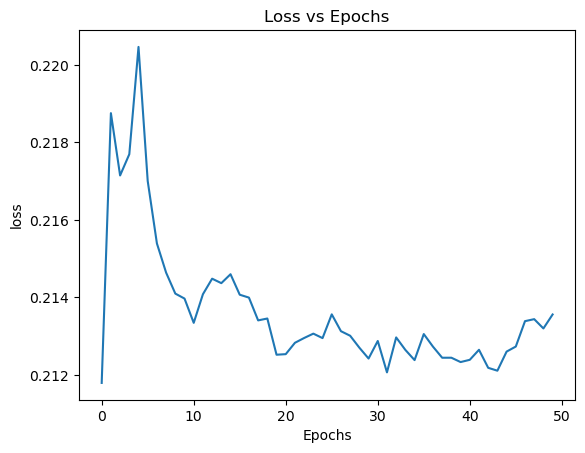

In [16]:
#plotting the loss
plt.plot(losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

Text(0, 0.5, 'Accuracy')

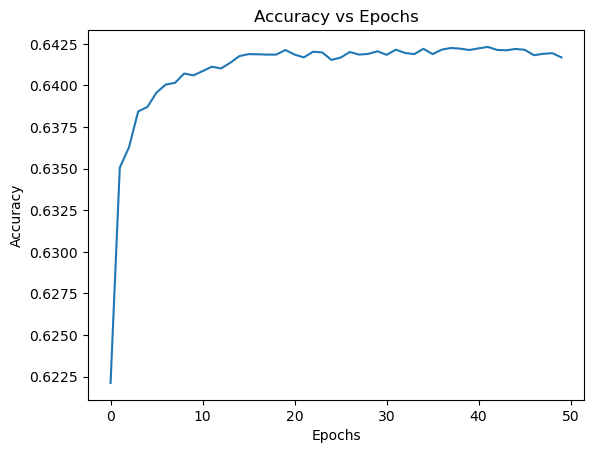

In [17]:
#plotting the accuracy
plt.plot(accur)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [18]:
for m,n in valloader:
    x = m

In [19]:
from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx

# Export the model
torch.onnx.export(model,                     # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "trained_model.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

In [20]:
import onnx

onnx_model = onnx.load("trained_model.onnx")
onnx.checker.check_model(onnx_model)

In [21]:
torch.save(model, "trained_model.pt")